## Penguin Species - ML Modelling
Using clustering models to catogorise penguins by species. Using KMeans and Spectral Clustering and comparing the resuts, before exploring Hierarchical clustering.

In [462]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Load dataset from seaborn

In [463]:
penguins_df = sns.load_dataset("penguins")

In [464]:
penguins_df = pd.DataFrame(penguins_df)

### Data Cleaning

Check data for null entries

In [465]:
penguins_df.isnull().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

In [466]:
penguins_df.loc[penguins_df.isna().any(axis=1)]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,NaN
47,Adelie,Dream,37.5,18.9,179.0,2975.0,NaN
246,Gentoo,Biscoe,44.5,14.3,216.0,4100.0,NaN
286,Gentoo,Biscoe,46.2,14.4,214.0,4650.0,NaN
324,Gentoo,Biscoe,47.3,13.8,216.0,4725.0,NaN
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,NaN


Use the random sample imputer function to replace the null 'sex' entries with random samples from the 'sex' column.

In [467]:
from feature_engine.imputation import RandomSampleImputer

rsi = RandomSampleImputer(variables=['sex'])
rsi.fit(penguins_df)
penguins_df = rsi.transform(penguins_df)

This just leaves nulls within some of the penguins measurements.

In [468]:
penguins_df.isnull().sum()

species              0
island               0
bill_length_mm       2
bill_depth_mm        2
flipper_length_mm    2
body_mass_g          2
sex                  0
dtype: int64

Looking at the remaining nulls, we can see they are shared across just two samples.

In [469]:
penguins_df.loc[penguins_df.isna().any(axis=1)]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,Female
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,Male


As these two samples are missing all their entries it makes sense to remove these samples from the data.

In [470]:
penguins_df = penguins_df.dropna()

Resetting the index after removing the two samples.

In [471]:
penguins_df = penguins_df.reset_index()
penguins_df = penguins_df.drop(columns='index')
penguins_df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male
...,...,...,...,...,...,...,...
337,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,Female
338,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
339,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
340,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


Plotting the data to get an overview of the features and their relationships to each other.

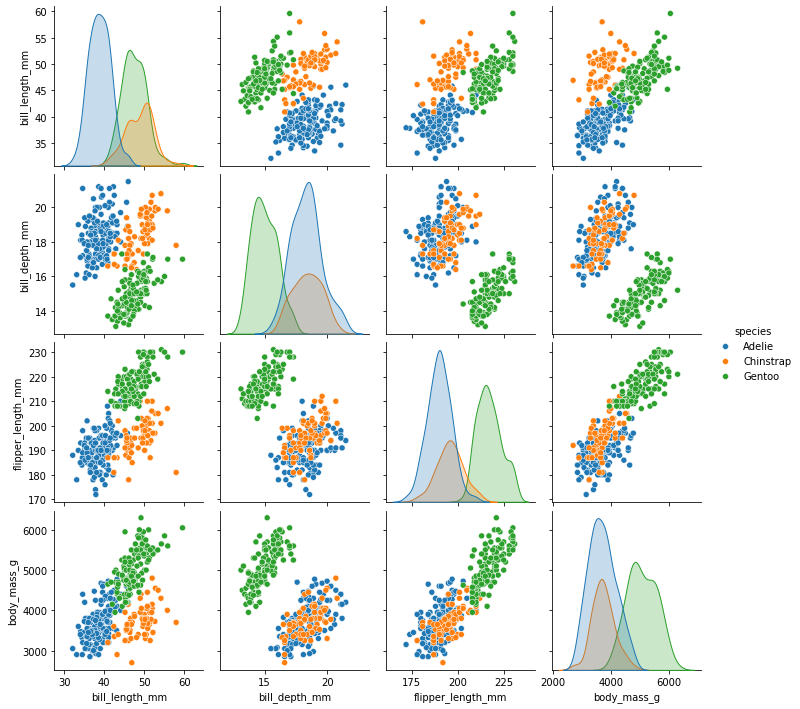

In [472]:
sns.pairplot(penguins_df,hue='species')

### Encoding Features

In [473]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

Encoding the sex feature to display either 0 for female or 1 for male.

In [474]:
penguins_df['sex2']= OrdinalEncoder().fit_transform(penguins_df[['sex']])

Encoding the island feature with one hot encoder.

In [475]:
one_hot_encoder = OneHotEncoder()
island_encode = one_hot_encoder.fit_transform(penguins_df[['island']])
island_encode = island_encode.toarray()
island_encode_df = pd.DataFrame(island_encode, columns=one_hot_encoder.get_feature_names_out(['island']))

penguins_df = pd.concat([penguins_df, island_encode_df],axis=1)  


Dropping the now defunk island and sex columns, and renaming the sex column.

In [479]:
penguins_df = penguins_df.drop(columns=['island','sex'])
penguins_df = penguins_df.rename(columns={'sex2':'sex'})

Removing the species feature from the dataframe, as this will be the cluster that we are trying to identify.

In [352]:
penguins_df_c = penguins_df.drop(columns='species')

I created a new df for the species as this can be used to check how succesful the ml clustering is.

In [ ]:
species_df = penguins_df['species']

The main reason for carrying out the previous encoding was to practise these techniques. As now I will be removing these features before carrying out the unsupervised machine learning.

In [353]:
penguins_df_c = penguins_df_c.drop(columns=['sex','island_Biscoe','island_Dream','island_Torgersen'])

### Unsupervised ML - KMeans and Spectral Clustering

In [356]:
from sklearn.cluster import KMeans,SpectralClustering
from sklearn.preprocessing import StandardScaler

Standardising the data. I did initially run it un-standardised, but found that the performance improved drastically after standardising. It would have been better if I kept the original method and made a comparison between them.

In [480]:
std_scaler = StandardScaler()

penguins_df_c = std_scaler.fit_transform(penguins_df_c)
penguins_df_c = pd.DataFrame(penguins_df_c, columns=['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g'])
penguins_df_c

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,-0.884499,0.785449,-1.418347,-0.564142
1,-0.811126,0.126188,-1.062250,-0.501703
2,-0.664380,0.430462,-0.421277,-1.188532
3,-1.324737,1.089724,-0.563715,-0.938776
4,-0.847812,1.748985,-0.777373,-0.689020
...,...,...,...,...
337,0.601305,-1.750171,0.931890,0.903175
338,0.527932,-1.445897,1.003109,0.809516
339,1.188289,-0.735923,1.501644,1.933419
340,0.234440,-1.192335,0.789451,1.246590


In [359]:
number_of_clusters = 3

Creating the KMeans model and fitting the data to it. Then creating a new dataframe with the cluster assignments. 

In [360]:
kmeans = KMeans(n_clusters=number_of_clusters, n_init='auto')
kmeans_assignments = kmeans.fit_predict(penguins_df_c)

kmeans_assignments = pd.DataFrame(kmeans_assignments)

Creating the Spectral Clustering model and fitting the data to it. Then creating a new dataframe with the cluster assignments. 

In [481]:
spect = SpectralClustering(n_clusters=number_of_clusters,affinity='nearest_neighbors')
spect_assignments = spect.fit_predict(penguins_df_c)

spect_assignments = pd.DataFrame(spect_assignments)

Adding the cluster assignemnt dataframes to the main dataframe.

In [362]:
penguins_df_cm = pd.concat([penguins_df_c, kmeans_assignments],axis=1,join='inner')  
penguins_df_cm = penguins_df_cm.rename(columns={0:'Cluster'})
penguins_df_cm = pd.concat([penguins_df_cm, spect_assignments],axis=1,join='inner')  
penguins_df_cm = penguins_df_cm.rename(columns={0:'Spect'})


Adding the species feature back into the data, as it is required for the plotting.

In [365]:
penguins_df_cm_s = pd.concat([penguins_df_cm, species_df],axis=1,join='inner')

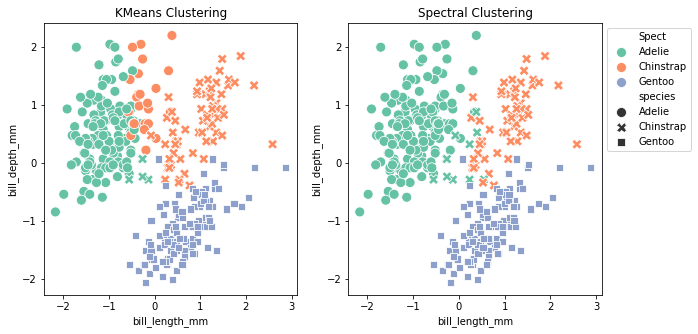

In [508]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('KMeans Clustering')
sns.scatterplot(data=penguins_df_cm_s,x='bill_length_mm',y='bill_depth_mm',hue='Cluster',palette='Set2',style='species',s=100,legend=False)
plt.subplot(1,2,2)
plt.title('Spectral Clustering')
ax = sns.scatterplot(data=penguins_df_cm_s,x='bill_length_mm',y='bill_depth_mm',hue='Spect',palette='Set2',style='species',s=100)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

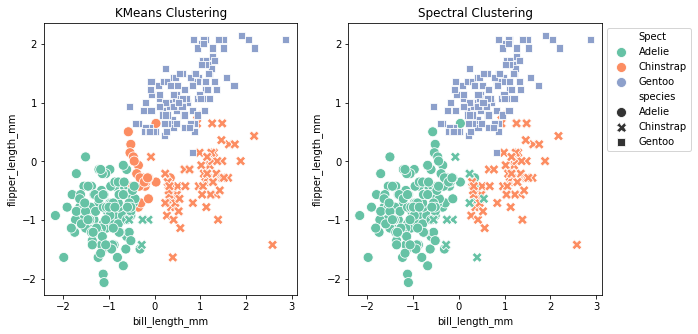

In [510]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('KMeans Clustering')
sns.scatterplot(data=penguins_df_cm_s,x='bill_length_mm',y='flipper_length_mm',hue='Cluster',palette='Set2',style='species',s=100,legend=False)
plt.subplot(1,2,2)
plt.title('Spectral Clustering')
ax = sns.scatterplot(data=penguins_df_cm_s,x='bill_length_mm',y='flipper_length_mm',hue='Spect',palette='Set2',style='species',s=100)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

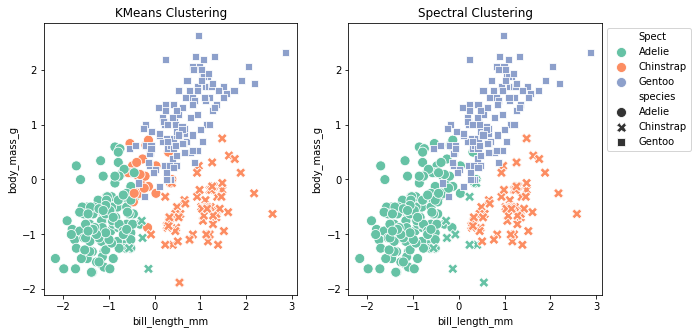

In [511]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('KMeans Clustering')
sns.scatterplot(data=penguins_df_cm_s,x='bill_length_mm',y='body_mass_g',hue='Cluster',palette='Set2',style='species',s=100,legend=False)
plt.subplot(1,2,2)
plt.title('Spectral Clustering')
ax = sns.scatterplot(data=penguins_df_cm_s,x='bill_length_mm',y='body_mass_g',hue='Spect',palette='Set2',style='species',s=100)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

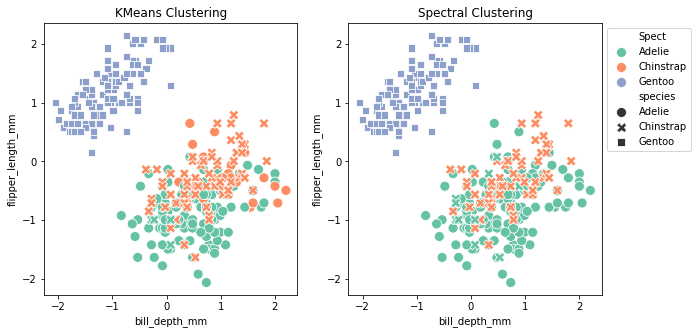

In [512]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('KMeans Clustering')
sns.scatterplot(data=penguins_df_cm_s,x='bill_depth_mm',y='flipper_length_mm',hue='Cluster',palette='Set2',style='species',s=100,legend=False)
plt.subplot(1,2,2)
plt.title('Spectral Clustering')
ax = sns.scatterplot(data=penguins_df_cm_s,x='bill_depth_mm',y='flipper_length_mm',hue='Spect',palette='Set2',style='species',s=100)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

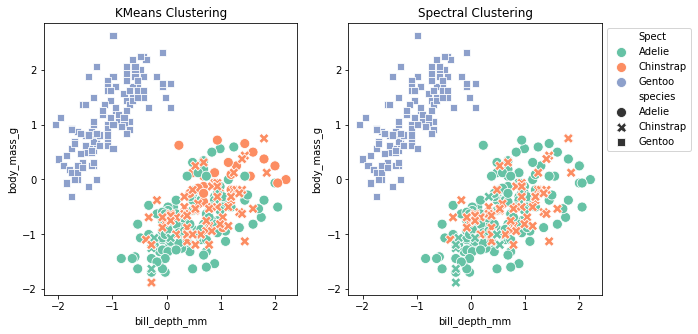

In [513]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('KMeans Clustering')
sns.scatterplot(data=penguins_df_cm_s,x='bill_depth_mm',y='body_mass_g',hue='Cluster',palette='Set2',style='species',s=100,legend=False)
plt.subplot(1,2,2)
plt.title('Spectral Clustering')
ax = sns.scatterplot(data=penguins_df_cm_s,x='bill_depth_mm',y='body_mass_g',hue='Spect',palette='Set2',style='species',s=100)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

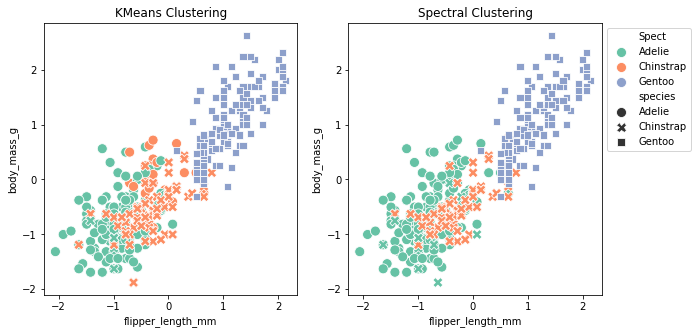

In [514]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('KMeans Clustering')
sns.scatterplot(data=penguins_df_cm_s,x='flipper_length_mm',y='body_mass_g',hue='Cluster',palette='Set2',style='species',s=100,legend=False)
plt.subplot(1,2,2)
plt.title('Spectral Clustering')
ax = sns.scatterplot(data=penguins_df_cm_s,x='flipper_length_mm',y='body_mass_g',hue='Spect',palette='Set2',style='species',s=100)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


In [375]:
unique_species = penguins_df_cm_s['species'].unique()

for species in unique_species:
    max = penguins_df_cm_s[penguins_df_cm_s['species'] == species].Cluster.value_counts().idxmax()
    penguins_df_cm_s.Cluster = penguins_df_cm_s.Cluster.replace(max,species)

for species in unique_species:
    max = penguins_df_cm_s[penguins_df_cm_s['species'] == species].Spect.value_counts().idxmax()
    penguins_df_cm_s.Spect = penguins_df_cm_s.Spect.replace(max,species)



In [376]:
penguins_df_cm_s

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,Cluster,Spect,species
0,-0.884499,0.785449,-1.418347,-0.564142,Adelie,Adelie,Adelie
1,-0.811126,0.126188,-1.062250,-0.501703,Adelie,Adelie,Adelie
2,-0.664380,0.430462,-0.421277,-1.188532,Adelie,Adelie,Adelie
3,-1.324737,1.089724,-0.563715,-0.938776,Adelie,Adelie,Adelie
4,-0.847812,1.748985,-0.777373,-0.689020,Adelie,Adelie,Adelie
...,...,...,...,...,...,...,...
337,0.601305,-1.750171,0.931890,0.903175,Gentoo,Gentoo,Gentoo
338,0.527932,-1.445897,1.003109,0.809516,Gentoo,Gentoo,Gentoo
339,1.188289,-0.735923,1.501644,1.933419,Gentoo,Gentoo,Gentoo
340,0.234440,-1.192335,0.789451,1.246590,Gentoo,Gentoo,Gentoo


In [377]:
penguins_df_cm_s[penguins_df_cm_s.species == 'Adelie'].Cluster.value_counts()

Cluster
Adelie       127
Chinstrap     24
Name: count, dtype: int64

In [378]:
penguins_df_cm_s[penguins_df_cm_s.species == 'Chinstrap'].Cluster.value_counts()

Cluster
Chinstrap    63
Adelie        5
Name: count, dtype: int64

In [379]:
penguins_df_cm_s[penguins_df_cm_s.species == 'Gentoo'].Cluster.value_counts()

Cluster
Gentoo    123
Name: count, dtype: int64

In [380]:
penguins_df_cm_s[penguins_df_cm_s.species == 'Adelie'].Spect.value_counts()

Spect
Adelie    151
Name: count, dtype: int64

In [381]:
penguins_df_cm_s[penguins_df_cm_s.species == 'Chinstrap'].Spect.value_counts()

Spect
Chinstrap    57
Adelie       11
Name: count, dtype: int64

In [382]:
penguins_df_cm_s[penguins_df_cm_s.species == 'Gentoo'].Spect.value_counts()

Spect
Gentoo    123
Name: count, dtype: int64

In [383]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [384]:
accuracy_score(penguins_df_cm_s['species'],penguins_df_cm_s['Cluster'])

0.9152046783625731

In [385]:
accuracy_score(penguins_df_cm_s['species'],penguins_df_cm_s['Spect'])

0.9678362573099415

In [386]:
print(classification_report(penguins_df_cm_s['species'],penguins_df_cm_s['Cluster']))

              precision    recall  f1-score   support

      Adelie       0.96      0.84      0.90       151
   Chinstrap       0.72      0.93      0.81        68
      Gentoo       1.00      1.00      1.00       123

    accuracy                           0.92       342
   macro avg       0.90      0.92      0.90       342
weighted avg       0.93      0.92      0.92       342



In [387]:
print(classification_report(penguins_df_cm_s['species'],penguins_df_cm_s['Spect']))

              precision    recall  f1-score   support

      Adelie       0.93      1.00      0.96       151
   Chinstrap       1.00      0.84      0.91        68
      Gentoo       1.00      1.00      1.00       123

    accuracy                           0.97       342
   macro avg       0.98      0.95      0.96       342
weighted avg       0.97      0.97      0.97       342



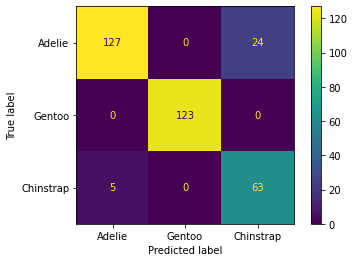

In [388]:
cfm = confusion_matrix(y_true=penguins_df_cm_s['species'],y_pred=penguins_df_cm_s['Cluster'],labels=['Adelie','Gentoo','Chinstrap'])

disp = ConfusionMatrixDisplay(confusion_matrix=cfm,display_labels=['Adelie','Gentoo','Chinstrap'])
disp.plot()
plt.show()

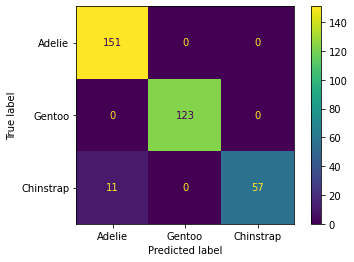

In [389]:
cfm = confusion_matrix(y_true=penguins_df_cm_s['species'],y_pred=penguins_df_cm_s['Spect'],labels=['Adelie','Gentoo','Chinstrap'])

disp = ConfusionMatrixDisplay(confusion_matrix=cfm,display_labels=['Adelie','Gentoo','Chinstrap'])
disp.plot()
plt.show()

In [390]:
from sklearn.metrics import davies_bouldin_score

In [391]:
cluster_labels = kmeans.labels_
spect_labels = spect.labels_

db_index_c = davies_bouldin_score(penguins_df_c, cluster_labels)
db_index_s = davies_bouldin_score(penguins_df_c, spect_labels)

print('KMeans Clustering DB Index', db_index_c)
print('Spectral Clustering DB Index', db_index_s)


KMeans Clustering DB Index 0.9435534346634803
Spectral Clustering DB Index 0.8446064841494118


### Hierarchical Clustering

In [392]:
from scipy.cluster.hierarchy import linkage

In [435]:
# Using the linkage function to perform hierarchical clustering
# 'ward' method minimizes the variance of clusters being merged
# Z = linkage(penguins_df_c, method=     )
# Z = linkage(penguins_df_c, method='average')
# Z = linkage(penguins_df_c, method='median')
# Z = linkage(penguins_df_c, method='complete')  # farthest point between clusters
# Z = linkage(penguins_df_c, method='single')  # nearest distance between clusters
Z = linkage(penguins_df_c, method='weighted')
# Z = linkage(penguins_df_c, method='ward')

Z

array([[2.25000000e+02, 3.11000000e+02, 1.08991018e-01, 2.00000000e+00],
       [2.60000000e+02, 3.12000000e+02, 1.08991018e-01, 2.00000000e+00],
       [3.50000000e+01, 1.06000000e+02, 1.26537458e-01, 2.00000000e+00],
       ...,
       [6.48000000e+02, 6.76000000e+02, 2.81711494e+00, 1.23000000e+02],
       [6.77000000e+02, 6.79000000e+02, 3.19773795e+00, 2.19000000e+02],
       [6.80000000e+02, 6.81000000e+02, 4.06487361e+00, 3.42000000e+02]])

In [436]:
from scipy.cluster.hierarchy import dendrogram

In [437]:
species_labels = penguins_df_cm_s['species'].to_list()

Text(0, 0.5, 'Distance')

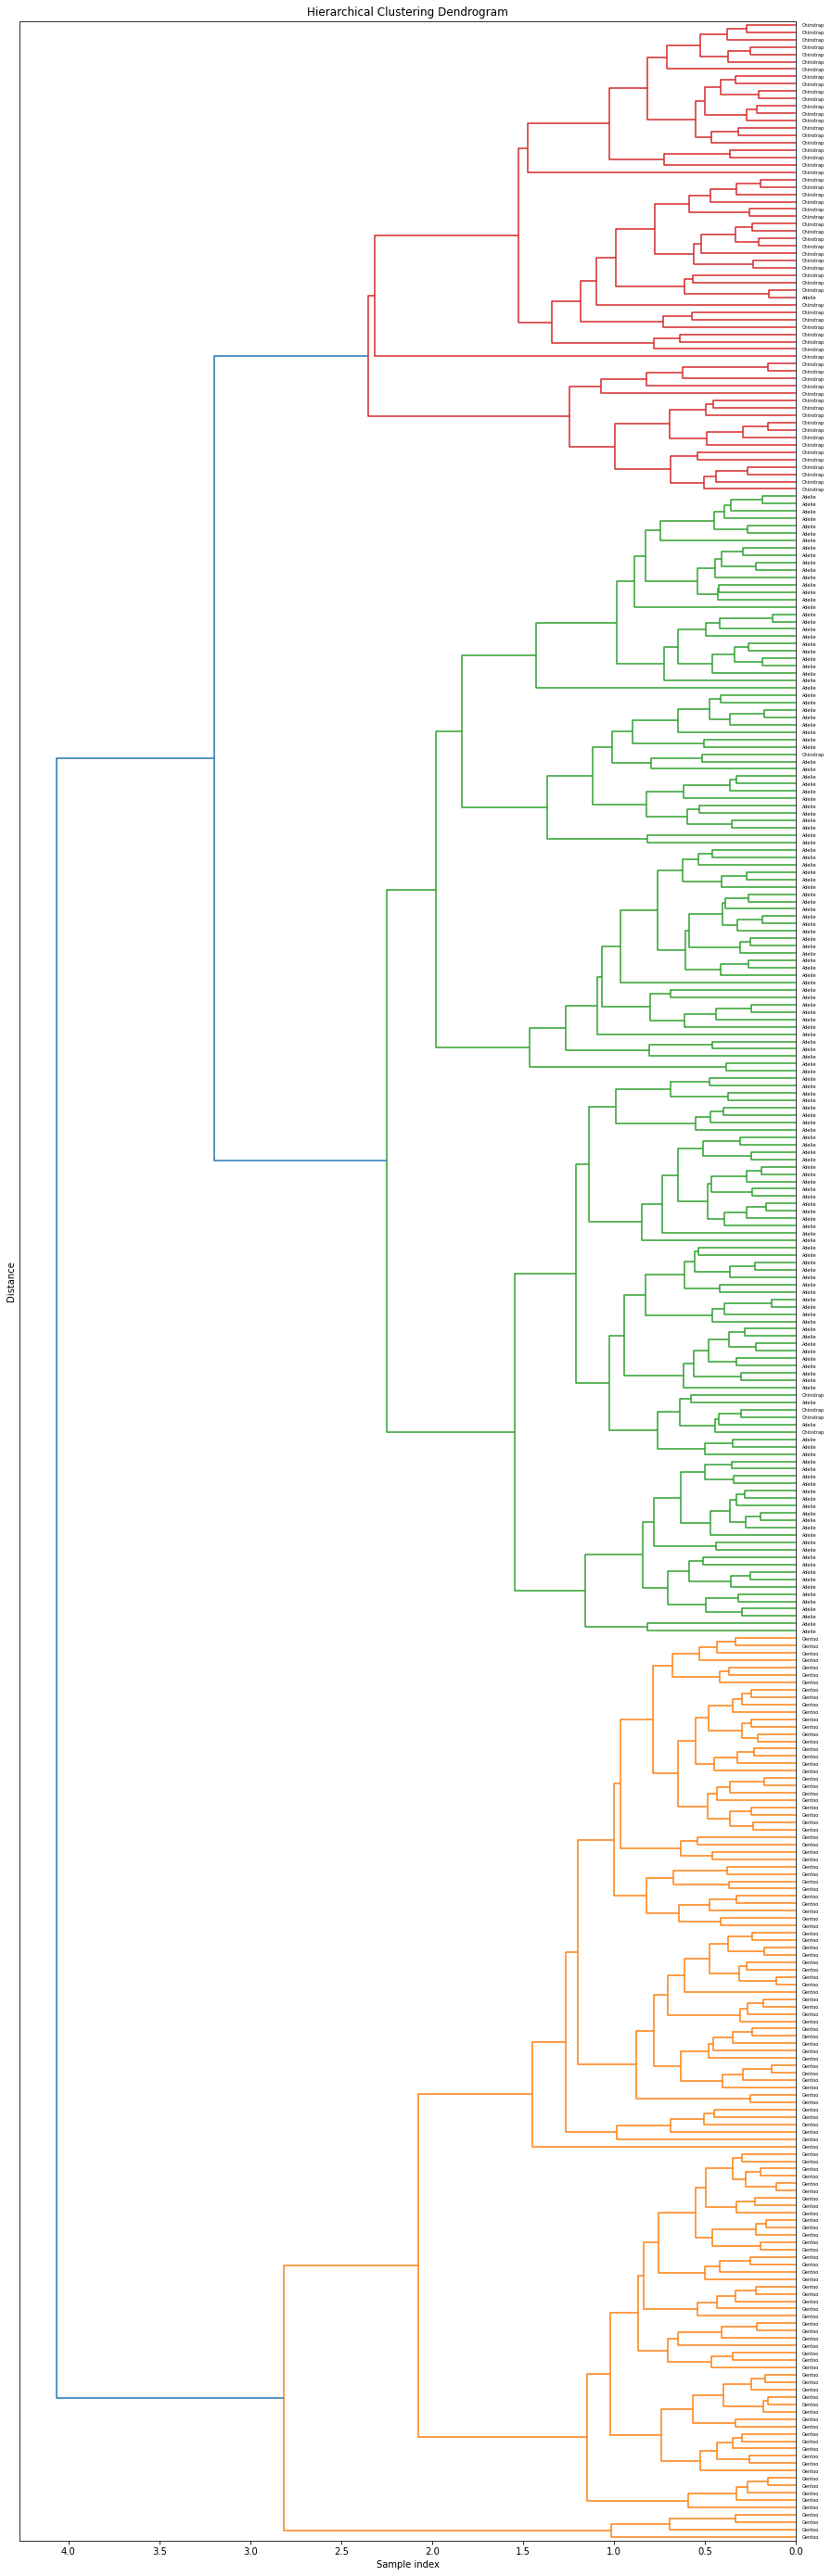

In [438]:
plt.figure(figsize=(15, 50))
dendrogram(Z, labels=species_labels, orientation='left')
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Distance")
